# Classifiers using neuro-imaging data

In [1]:
import pandas as pd
import numpy as np
from numpy import random, arange
import seaborn as sns
import patsy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder, RobustScaler

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

# Import relevant sklearn class/function related to evaluation
import sklearn.metrics
from imblearn.under_sampling import RandomUnderSampler

#Smote oversampling 
import smote_variants as sv

#Harmonisation methods
from neuroCombat import neuroCombat
from combat.pycombat import pycombat
import covbat

## Data Pre-Processing

In [2]:

img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
demographics = pd.read_csv("../data/PTDEMOG.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [3]:
img_adni2.replace("scmri", "sc", inplace=True)
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)
adni2 = img_adni2.loc[img_adni2['VISCODE2'] == "sc"]
adni3 = img_adni3.loc[img_adni3['VISCODE2'] == "sc"]
adni1 = img_adni1.loc[img_adni1['VISCODE'] == 'bl']

In [4]:
# Select interesting columns

# Quality Metrics
QMs = []
# Cortical thickness averages
TAs = []


for col in adni2.columns:
    
    if col.endswith('QC'):
        QMs.append(col)
    
    
    if col.endswith('TA'):
        TAs.append(col)

TAs.append("RID")
TAs2 = TAs.copy()
TAs2.append("VISCODE")
QMs = QMs[:-2]
TAs.append("VISCODE2")


In [5]:
dxbl_subset = dx.loc[:,["VISCODE", "VISCODE2", "RID", "DXCHANGE","DXCURREN","DIAGNOSIS", "PTID", "SITEID", "USERDATE"]].copy()
dxbl_subset["USERDATE"] = pd.to_datetime(dxbl_subset["USERDATE"])
dxbl_subset["USERDATE"] = pd.DatetimeIndex(dxbl_subset["USERDATE"]).year

imgdx2 = pd.merge(adni2.loc[:,TAs+QMs].copy(), dxbl_subset, on=["RID", "VISCODE2"])
imgdx3 = pd.merge(adni3.loc[:,TAs+QMs].copy(), dxbl_subset, on=["RID", "VISCODE2"])
imgdx1 = pd.merge(adni1.loc[:,TAs2+QMs].copy(), dxbl_subset, on=["RID", "VISCODE"])

In [6]:
imgdx1["PTID"].append(imgdx2['PTID'].append(imgdx3['PTID'])).nunique()

1598

In [7]:

imgdx2.loc[(imgdx2["DXCHANGE"] == 1) | (imgdx2["DXCHANGE"] == 4) |(imgdx2["DXCHANGE"] == 6), 'DXCHANGE'] = 1
imgdx2.loc[(imgdx2["DXCHANGE"] == 2) | (imgdx2["DXCHANGE"] == 5) |(imgdx2["DXCHANGE"] == 7), 'DXCHANGE'] = 2
imgdx2.loc[(imgdx2["DXCHANGE"] == 3) | (imgdx2["DXCHANGE"] == 8) |(imgdx2["DXCHANGE"] == 9), 'DXCHANGE'] = 3


In [8]:
img = imgdx1.append(imgdx2.append(imgdx3))

In [9]:
for qm in QMs:
    
    img.loc[img[qm] == "Fail",qm] = -1
    img.loc[img[qm] == "Partial",qm] = 0
    img.loc[img[qm] == "Pass",qm] = 1
    img.loc[(img[qm] != 0) & (img[qm] != 1) & (img[qm] != -1),qm] = 0

In [10]:
len(img)

1759

In [11]:
# Get covariates
img_cov = pd.merge(img, demographics.loc[:,["RID", "VISCODE2", "PTGENDER", "PTHAND", "PTDOBYY"]], on=["RID", "VISCODE2"])

In [12]:
img_cov["AGE"] = img_cov["USERDATE"] - img_cov["PTDOBYY"]


In [13]:
# Merge diagnosis

img_cov['DIAGNOSIS'] = img_cov['DIAGNOSIS'].fillna(img_cov['DXCHANGE'])
img_cov['DIAGNOSIS'] = img_cov['DIAGNOSIS'].fillna(img_cov['DXCURREN'])
img_cov.drop(['DXCURREN', 'DXCHANGE'], axis=1, inplace=True)

In [14]:
img_cov.dropna(inplace=True)

In [15]:
img_cov = img_cov.drop_duplicates("PTID")

<ipython-input-16-af0736e07413>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dems['DIAGNOSIS'][dems['DIAGNOSIS'] == 1] = 'Sane'


Males: 664 ->47.942238267148014%
Females: 721 ->52.05776173285198%


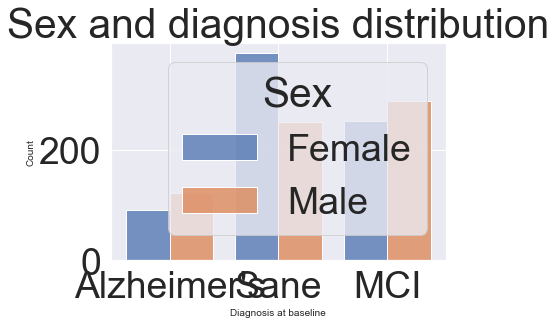

In [16]:
#Sex, Age, and diagnosis distrib
dems = img_cov.copy()
sex = dems['PTGENDER'].copy()
sex[sex==1] = "Male"
sex[sex==2] = "Female"
dems['DIAGNOSIS'][dems['DIAGNOSIS'] == 1] = 'Sane'
dems['DIAGNOSIS'][dems['DIAGNOSIS'] == 2] = 'MCI'
dems['DIAGNOSIS'][dems['DIAGNOSIS'] == 3] = 'Alzheimer\'s'
males = len(sex[sex=="Male"])
females = len(sex[sex=="Female"])
total = (len(sex))
dems['Sex'] = sex

#Plot
sns.set_style("dark")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set(rc={'figure.figsize':(12.7,10.27)})
sns.set(font_scale=3.4)
hist_plot = sns.histplot(data=dems, x="DIAGNOSIS", hue="Sex", multiple="dodge", shrink=.8).set(title='Sex and diagnosis distribution', xlabel='Diagnosis at baseline')[0]
fig = hist_plot.get_figure()
fig.savefig("sexdiag.png") 

print("Males: " + str(males) + " ->" + str(males / total *100)+ "%")
print("Females: " + str(females) + " ->" + str(females / total *100)+ "%")

In [17]:
img_cov.describe()

,ST102TA,ST103TA,ST104TA,ST105TA,ST106TA,ST107TA,ST108TA,ST109TA,ST110TA,ST111TA,...,ST98TA,ST99TA,RID,DIAGNOSIS,SITEID,USERDATE,PTGENDER,PTHAND,PTDOBYY,AGE
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,...,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,2.278358,2.681552,2.458812,2.596168,2.326003,1.557303,1.906316,2.420336,2.344900,2.272723,...,2.365835,2.795666,5380.818051,1.701083,31.321300,2014.499639,1.520578,1.098917,1942.664260,71.835379
std,0.178284,0.305840,0.160530,0.221359,0.158360,0.146858,0.148441,0.191241,0.177477,0.167551,...,0.186658,0.189568,971.739976,0.720393,18.158861,3.364883,0.499757,0.298658,8.497317,7.329392
min,1.611000,1.573000,1.782000,1.694000,1.779000,1.171000,1.482000,1.118000,1.650000,1.564000,...,1.784000,1.696000,4001.000000,1.000000,1.000000,2011.000000,1.000000,1.000000,1920.000000,50.000000
25%,2.168000,2.492000,2.350000,2.448000,2.223000,1.452000,1.811000,2.303000,2.241000,2.172000,...,2.235000,2.697000,4509.000000,1.000000,16.000000,2012.000000,1.000000,1.000000,1937.000000,67.000000
50%,2.284000,2.694000,2.468000,2.589000,2.330000,1.544000,1.906000,2.415000,2.361000,2.277000,...,2.359000,2.814000,5090.000000,2.000000,31.000000,2013.000000,2.000000,1.000000,1943.000000,72.000000
75%,2.396000,2.895000,2.572000,2.750000,2.427000,1.656000,2.001000,2.534000,2.465000,2.390000,...,2.497000,2.921000,6369.000000,2.000000,47.000000,2018.000000,2.000000,1.000000,1948.000000,77.000000
max,2.906000,3.505000,2.951000,3.512000,2.853000,2.127000,2.630000,3.098000,2.804000,2.846000,...,2.891000,3.258000,7066.000000,3.000000,63.000000,2022.000000,2.000000,2.000000,1971.000000,91.000000


In [18]:
# Get the number of sites
img_cov['SITEID'].nunique()

62

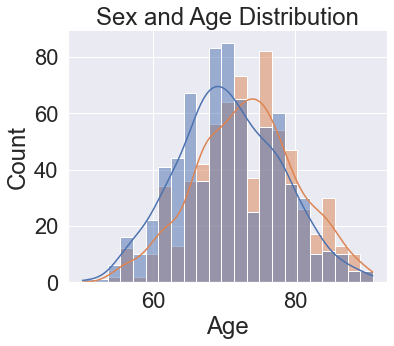

In [19]:
dems = img_cov.copy()
sex = dems['PTGENDER'].copy()
sex[sex==1] = "Male"
sex[sex==2] = "Female"
dems['Sex'] = sex
sns.set(font_scale=2)
dist_plot = sns.displot(data=dems, x='AGE', hue="Sex", kde=True, aspect=1.2, legend=False).set(title='Sex and Age Distribution', xlabel='Age')
fig = dist_plot.fig
fig.savefig("sexage.png") 

In [20]:
img = img_cov

## Alzheimer's classifier

Here, we wish to creater a classifier that is able to distinguish patients which have dementia/alzheimer's from patients that either have MCI or do not have any problem.
This classifier uses cross sectional brain imaging data.

### Feature selection

In [21]:

img_sub = img[~(img["DIAGNOSIS"] == 2)]
img_sub.dropna(inplace=True)
Y = img_sub['DIAGNOSIS']
X = img_sub.drop(['DIAGNOSIS'], axis=1)
Y[Y == 1] = 0
Y[Y == 3] = 1


<ipython-input-21-fdb4994b7c0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img_sub.dropna(inplace=True)
<ipython-input-21-fdb4994b7c0e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[Y == 1] = 0
C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-21-fdb4994b7c0e>:6: SettingWithCopyWarning: 


<Axes: xlabel='DIAGNOSIS', ylabel='Count'>

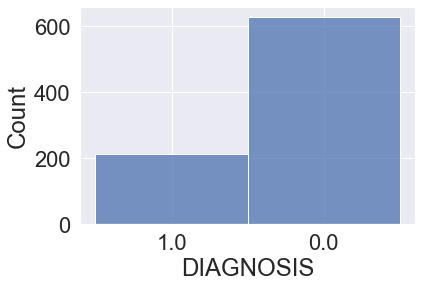

In [22]:
sns.histplot(Y.astype(str))

### Model training

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, train_size=0.6)

In [104]:
covs = X_train.loc[:,["AGE", "PTGENDER", "PTHAND"]].copy()
quality_metrics_train = X_train.loc[:, QMs].copy()
quality_metrics_test = X_test.loc[:,QMs].copy()

In [105]:
X_test = X_test.drop(["VISCODE", "VISCODE2", "PTID", "RID", "PTHAND", "AGE", "PTGENDER", "PTDOBYY", "USERDATE"] + QMs, axis=1)
X_train = X_train.drop(["VISCODE", "VISCODE2", "PTID", "RID", "PTHAND", "AGE", "PTGENDER", "PTDOBYY", "USERDATE"] + QMs, axis=1)

## ComBat harmonisation

In [84]:
covs_combat = covs.copy()
covs_combat['batch'] = X_train['SITEID']
covs_combat = covs_combat.loc[:,['PTGENDER', 'batch']]
categorical_cols = ['PTGENDER']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'

#Harmonization step:
data_combat = neuroCombat(dat=X_train.head(10).T.to_numpy(),
    covars=covs_combat.head(10),
    batch_col=batch_col,
    categorical_cols=categorical_cols)["data"]

data_combat

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features


LinAlgError: Singular matrix

In [35]:
data = np.genfromtxt('testdata.csv', delimiter=",", skip_header=1)

# Specifying the batch (scanner variable) as well as a biological covariate to preserve:
covars = {'batch':[1,1,1,1,1,2,2,2,2,2],
          'gender':[1,2,1,2,1,2,1,2,1,2]} 
covars = pd.DataFrame(covars)  

# To specify names of the variables that are categorical:
categorical_cols = ['gender']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'

#Harmonization step:
data_combat = neuroCombat(dat=data,
    covars=covars,
    batch_col=batch_col,
    categorical_cols=categorical_cols)["data"]

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


## CovBat

In [74]:
scanners = X_train['SITEID']
X_test.drop(['SITEID'], inplace=True, axis=1)
X_train.drop(['SITEID'], inplace=True, axis=1)


X_train_c = pycombat(X_train.transpose(), scanners, mod=mod).transpose()

X_train_c = pd.DataFrame(X_train_c)
X_train_c['y'] = list(y_train)
X_train_c = X_train_c.dropna()
y_train_c = X_train_c['y']
X_train_c.drop(['y'], inplace=True, axis=1)

Found 61 batches.

One batch has only one sample, try setting mean_only=True.



ValueError: Unable to coerce to Series, length must be 3: given 0

In [106]:
covs_covbat = covs.copy()
covs_covbat['batch'] = X_train['SITEID']
covs_covbat['outcome'] = y_train
#covs_covbat = covs_covbat.loc[:,['PTGENDER', 'batch', 'AGE', '']]

X_train.drop(['SITEID'], inplace=True, axis=1)
mod = patsy.dmatrix("~ AGE + outcome", covs_covbat, return_type="dataframe")

In [112]:
pheno = pd.read_table('bladder-pheno.txt', index_col=0)

dat = pd.read_table('bladder-expr.txt', index_col=0)

mod = patsy.dmatrix("~ age + cancer", pheno, return_type="dataframe")

FileNotFoundError: [Errno 2] No such file or directory: 'bladder-pheno.txt'

In [111]:
X_train_cov = covbat.covbat(X_train.T, scanners, mod, "AGE")

found 61 batches
found 1 numerical covariates...
	AGE
found 1 categorical variables:	outcome
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [98]:
scanners.isnull().values.any()

False

## NeuroHarmony

In [38]:
from neuroharmony import exclude_single_subject_groups, fetch_sample, Neuroharmony
from neuroharmony.data.rois import rois


X_train_nh = X_train.copy()
X_train_nh["PTGENDER"] = covs2['PTGENDER']
X_train_nh['PTHAND'] = covs2['PTHAND']
X_train_nh['AGE'] = covs2['AGE']
X_train_nh['scanner'] = covs2['batch']
X_train_nh['DIAGNOSIS'] = y_train

for qm in QMs:
    X_train_nh[qm] = quality_metrics_train[qm]
    
features = TAs[:-2]
covariates = ["PTGENDER", "PTHAND", "AGE", "scanner"]
exclude_vars = X_train_nh.columns[X_train_nh.isna().sum() != 0].to_list() + ['Dataset', 'DIAGNOSIS']
regression_features = [var for var in X_train_nh.columns if var not in (covariates + features + exclude_vars)]

eliminate_variance = ["scanner"]

scanners = X_train_nh['scanner'].unique()
n_scanners = len(scanners)


In [64]:
#Split train and test leaving one scanner out.
train_bool = X_train_nh['scanner'].isin(scanners[1:])
test_bool = X_train_nh['scanner'].isin(scanners[:1])
X_train_split = X_train_nh[train_bool]
X_test_split = X_train_nh[test_bool]
x_train, x_test = X_train_split, X_test_split
x_train = exclude_single_subject_groups(X_train_nh, covariates)

# Create the Neuroharmony model.
# Here you can establish the range of the hyperparameters via random search or give specific values.
harmony = Neuroharmony(
    features,
    regression_features,
    covariates,
    eliminate_variance,
    param_distributions=dict(
        RandomForestRegressor__n_estimators=[100, 200, 500],
        RandomForestRegressor__random_state=[42, 78],
        RandomForestRegressor__warm_start=[False, True],
    ),
    estimator_args=dict(n_jobs=1, random_state=42),
    randomized_search_args=dict(cv=5, n_jobs=8),
)
# Fit the model.
x_train_harmonized = harmony.fit_transform(x_train)

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\neuroharmony\models\neuroCombat.py:228: RuntimeWarning: divide by zero encountered in divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())
Randomized search of Neuroharmony hyperparameters: 100%|██████████| 68/68 [22:09<00:00, 19.56s/it]


In [67]:
x_train_harmonized = x_train_harmonized.loc[:,TAs[:-2]]

In [87]:
y_train

1002    0.0
722     1.0
1248    0.0
1199    0.0
920     0.0
       ... 
714     0.0
1180    0.0
1010    0.0
946     0.0
901     0.0
Name: DIAGNOSIS, Length: 505, dtype: float64

In [95]:
x_train_harmonized[x_train_harmonized.index == 1002]

,ST102TA,ST103TA,ST104TA,ST105TA,ST106TA,ST107TA,ST108TA,ST109TA,ST110TA,ST111TA,...,ST84TA,ST85TA,ST90TA,ST91TA,ST93TA,ST94TA,ST95TA,ST97TA,ST98TA,ST99TA
subject_index,,,,,,,,,,,,,,,,,,,,,
1002,2.463291,3.133856,2.597468,2.956057,2.392943,1.524612,2.081894,2.398835,2.537901,2.464561,...,2.670646,2.941564,2.612378,3.06464,2.467645,2.330019,2.869594,2.055991,2.628951,3.088129


In [69]:
def find_oversampler(X, y):

    dataset= {'data': np.array(X),
            'target': np.array(y),
            'name': 'diagnosis'}

    classifiers = [('sklearn.ensemble', 'GradientBoostingClassifier', {}),
                ('sklearn.ensemble', 'RandomForestClassifier', {}),
                ('sklearn.neural_network', 'MLPClassifier', {}),
                ('sklearn.tree', 'DecisionTreeClassifier', {})]

    oversamplers = sv.queries.get_all_oversamplers(n_quickest=2)

    os_params = sv.queries.generate_parameter_combinations(oversamplers,
                                                        n_max_comb=2)

    # samp_obj and cl_obj contain the oversampling and classifier objects which give the
    # best performance together
    samp_obj, cl_obj= sv.evaluation.model_selection(dataset=dataset,
                                                    oversamplers=os_params,
                                                    classifiers=classifiers,
                                                    validator_params={'n_splits': 2,
                                                                    'n_repeats': 1},
                                                    n_jobs= 5)
    print(samp_obj)
    return samp_obj, cl_obj

def k_fold_choose_model(X, y): 
    models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]
    models_accuracy = []
    #TODO: find argmax
    kfold = KFold(n_splits=10)
    for model in models:
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
        models_accuracy.append(cv_results.sum()/10)
        print(model, cv_results.sum()/10)

    return models[np.argmax(np.array(models_accuracy))]


def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    results = model.predict(X_test)
    x = zip(results, y_test)
    cf_matrix = sklearn.metrics.confusion_matrix(y_test, results)
    print(accuracy_score(y_test, results))
    print(balanced_accuracy_score(y_test, results))
    sns.heatmap(cf_matrix, annot=True, fmt='g')
    return model

#oversampler_norm = find_oversampler(X_train, y_train)
#oversampler_harm = find_oversampler(X_train_c, y_train_c)

In [70]:
from sklearn.metrics import RocCurveDisplay

def create_evaluate_model(X_test, y_test, X_train, y_train):
    #Use oversampling to tackle imbalance
    oversampler = find_oversampler(X_train, y_train)
    X_train_samp, y_train_samp = oversampler[0].sample(np.array(X_train),
                                np.array(y_train))
    # Now use undersampling
    rus = RandomUnderSampler(random_state=0)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train_samp, y_train_samp)
    
    # Perform feature selection
    #X_train_resampled, cols, colNames = selectFeatures(X_train_resampled, y_train_resampled)

    # Find best model type
    model = k_fold_choose_model(X_train_resampled, y_train_resampled)
    trained_model = evaluate_model(model, X_train, y_train, X_test, y_test)
   
    plt.rcParams['figure.figsize'] = [15, 10]
    svc_disp = RocCurveDisplay.from_estimator(trained_model, X_test, y_test)
    return trained_model

2023-04-10 18:41:33,034:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 1.5, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-04-10 18:41:33,037:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.5, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


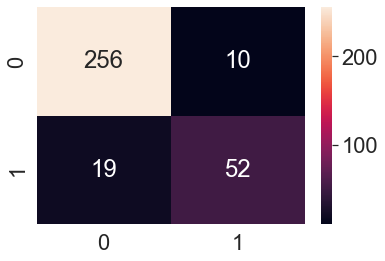

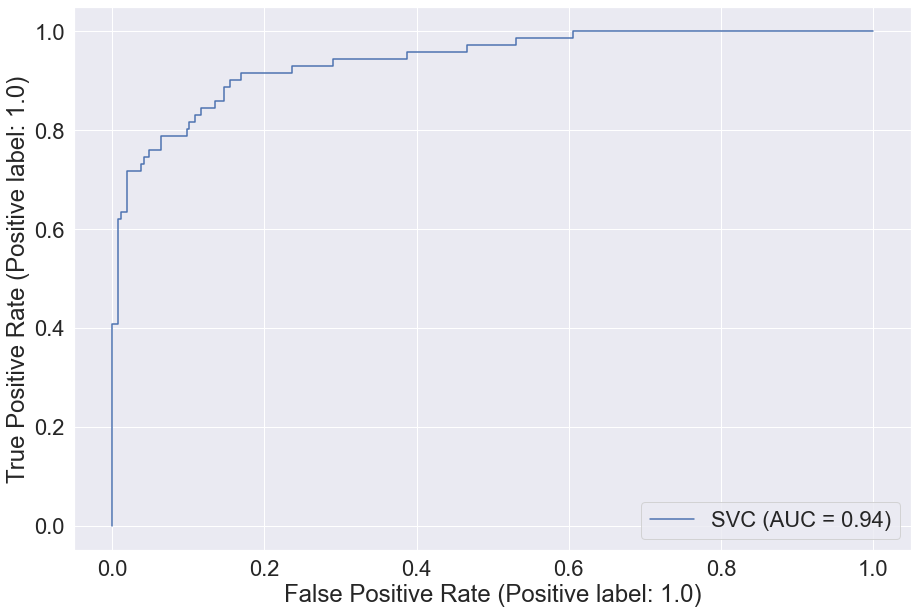

In [49]:
m1 = create_evaluate_model(X_test, y_test, X_train, y_train)

2023-04-10 19:39:25,944:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 1.5, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-04-10 19:39:25,950:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.5, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


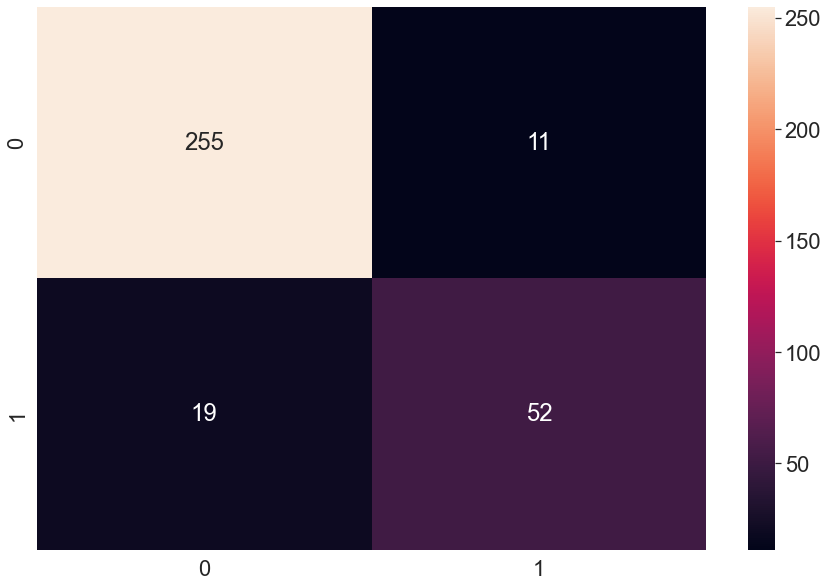

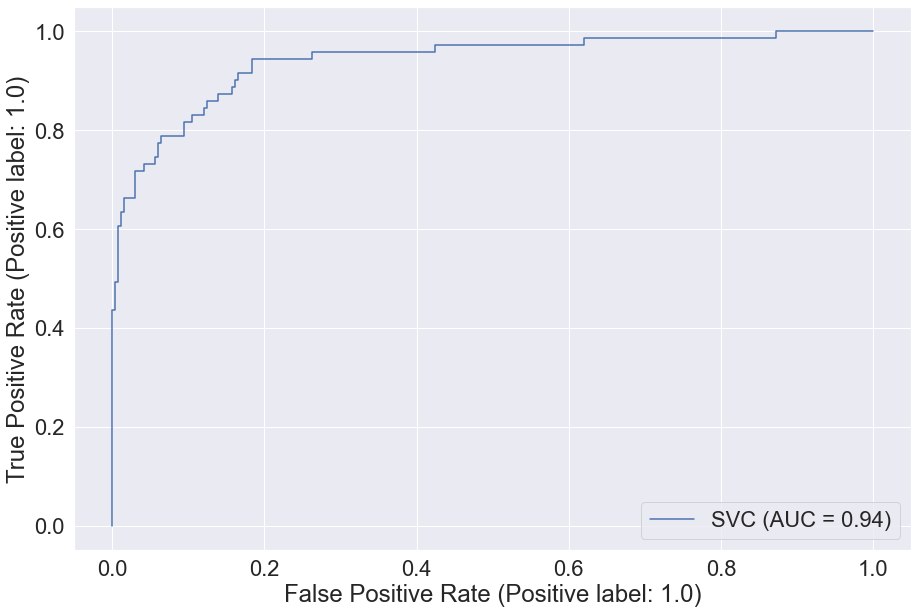

In [93]:
m_neuroharmony = create_evaluate_model(X_test, y_test, x_train_harmonized, y_train.loc[x_train_harmonized.index])

2023-03-24 12:38:20.589959: processing dataset: diagnosis


2023-03-24 12:38:32,894:INFO:polynom_fit_SMOTE_bus: Running sampling via ('polynom_fit_SMOTE_bus', "{'proportion': 0.5, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
2023-03-24 12:38:32,896:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.5, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


('polynom_fit_SMOTE_bus', "{'proportion': 0.5, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
GradientBoostingClassifier() 0.8395644283121596
RandomForestClassifier() 0.8516636418632789
SVC() 0.8815184513006654
DecisionTreeClassifier() 0.7891712038717483
MLPClassifier() 0.8918935269207502


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9247311827956989
0.8973970075835211


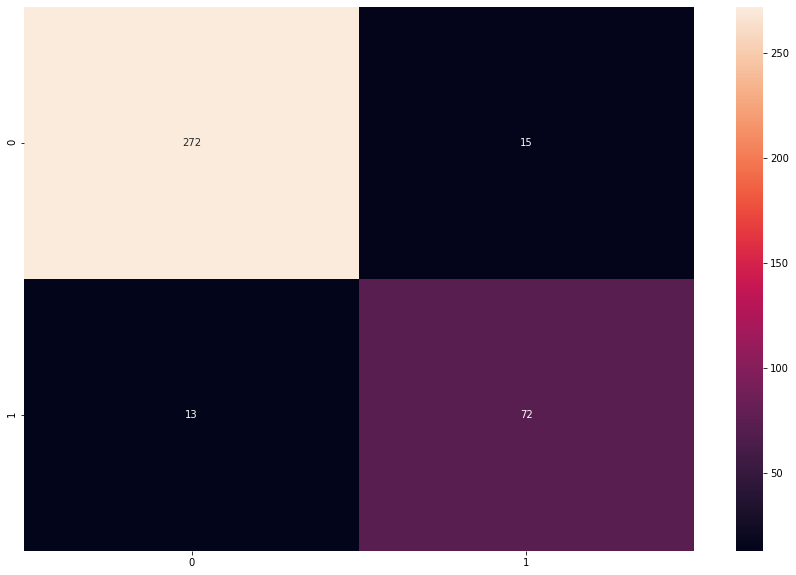

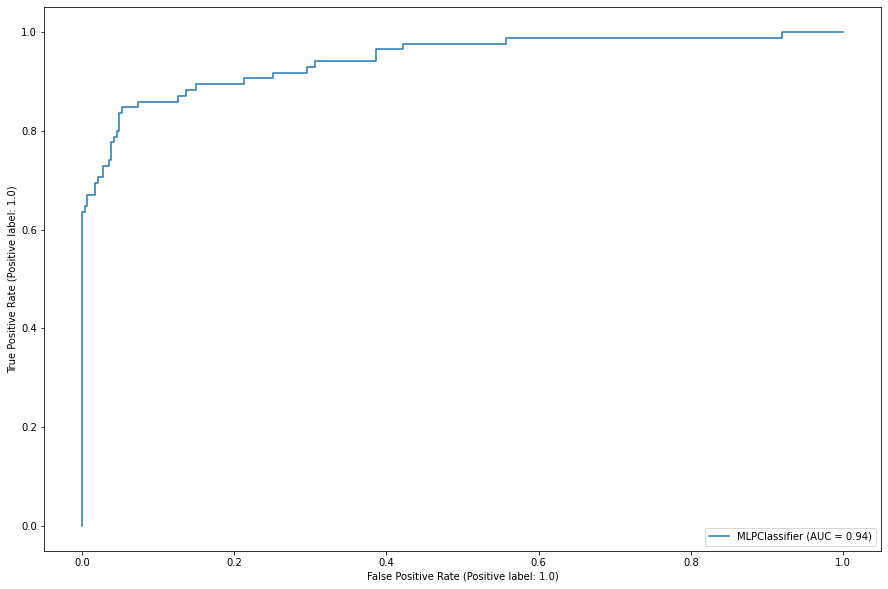

In [72]:
m2 = create_evaluate_model(X_test, y_test, X_train_c, y_train_c)

In [279]:
X_train_samp, y_train_samp = oversampler_norm[0].sample(np.array(X_train),
                                np.array(y_train))
X_train_samp_c, y_train_samp_c= oversampler_harm[0].sample(np.array(X_train_c),
                                np.array(y_train_c))

2023-03-17 17:06:13,912:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-03-17 17:06:13,915:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")
2023-03-17 17:06:13,924:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-03-17 17:06:13,926:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


In [280]:
rus = RandomUnderSampler(random_state=0)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train_samp, y_train_samp)
X_train_resampled_c, y_train_resampled_c = rus.fit_resample(X_train_samp_c, y_train_samp_c)

In [281]:
len(y_test[y_test == 0]) / (len(y_test))

0.7095959595959596

### Cross-validation

In [285]:
def selectFeatures(X, y):
    featureSelector = Lasso(alpha=0.005)
    featureSelector.fit(X, y)
    coefficients_importance = np.abs(featureSelector.coef_)
    cols = coefficients_importance != 0
    colNames = np.array(X.columns)[coefficients_importance != 0]

    return X.loc[:,cols].copy(), cols, colNames

In [286]:
featureSelector = Lasso( alpha=0.005)
featureSelector.fit(X_train_resampled, y_train_resampled)

featureSelector_c = Lasso( alpha=0.005)
featureSelector_c.fit(X_train_resampled_c, y_train_resampled_c)

Lasso(alpha=0.005)

In [287]:
coefficients = featureSelector.coef_
coefficients_c = featureSelector_c.coef_

In [288]:
importance = np.abs(coefficients)
importance_c = np.abs(coefficients_c)

In [289]:
cols = importance != 0
colNames = np.array(TAs[:68])[importance != 0]

cols_c = importance_c != 0
colNames_c = np.array(TAs[:68])[importance_c != 0]

In [290]:

X_train_resampled = X_train_resampled[:,cols]
X_train_resampled_c = X_train_resampled_c[:,cols_c]

In [291]:
def k_fold_choose_model(X, y): 
    models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]
    #TODO: find argmax
    kfold = KFold(n_splits=10)
    for model in models:
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
        print(model, cv_results.sum()/10)

In [292]:
k_fold_choose_model(X_train_resampled, y_train_resampled)

GradientBoostingClassifier() 0.8813311688311689
RandomForestClassifier() 0.8795779220779221
SVC() 0.9047077922077922
DecisionTreeClassifier() 0.8330194805194806
MLPClassifier() 0.9120454545454546


In [293]:
k_fold_choose_model(X_train_resampled_c, y_train_resampled_c)

GradientBoostingClassifier() 0.8580519480519481
RandomForestClassifier() 0.8471428571428572
SVC() 0.881461038961039
DecisionTreeClassifier() 0.7843506493506494
MLPClassifier() 0.8850974025974025


In [127]:
def find_best_model_params(model, grid, X, y):
    kfold = KFold(n_splits=10)


    grid_search = GridSearchCV(estimator = model, param_grid = grid, 
                          cv = kfold, n_jobs = -1, verbose = 2)

    grid_search.fit(X, y)
    print(grid_search.best_score_)
    print(grid_search.best_params_)

In [130]:
param_grid={'n_estimators':[100,500], 
            'learning_rate': [0.1,0.05,0.02],
            'max_depth':[4], 
            'min_samples_leaf':[3], 
            'max_features':[1.0] } 

rf = GradientBoostingClassifier()
find_best_model_params(rf, param_grid, X_train_resampled, y_train_resampled)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
0.8779761904761905
{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 500}


### Evaluation

In [240]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    results = rf.predict(X_test)
    x = zip(results, y_test)
    cf_matrix = sklearn.metrics.confusion_matrix(y_test, results)
    print(accuracy_score(y_test, results))
    print(balanced_accuracy_score(y_test, results))
    sns.heatmap(cf_matrix, annot=True, fmt='g')
    return model

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


0.8636363636363636
0.8397029243385425


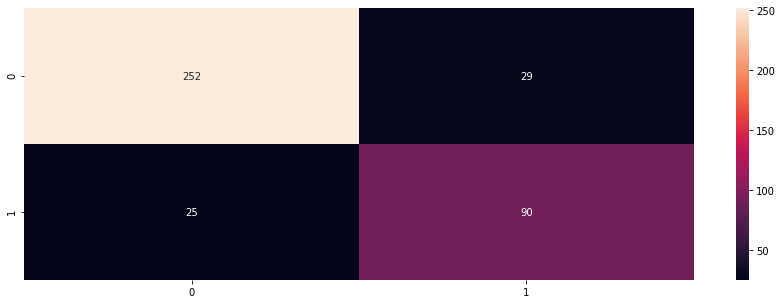

In [303]:
rf = MLPClassifier()
X_test_sel = X_test.loc[:,cols].copy()
trained_model = evaluate_model(rf, X_train_resampled, y_train_resampled, X_test_sel, y_test)

In [304]:

plt.rcParams['figure.figsize'] = [15, 5]
feat_imp = pd.Series(trained_model.feature_importances_, colNames).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


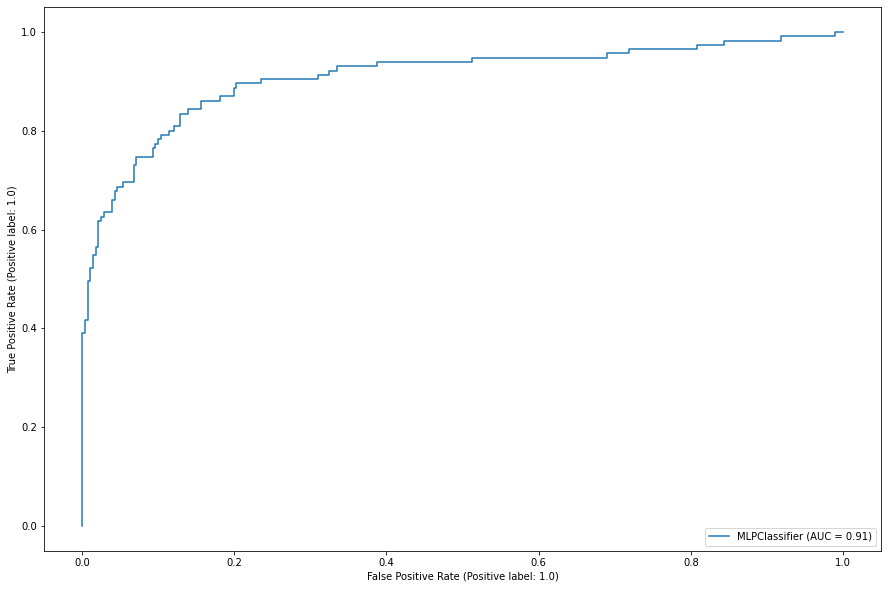

In [305]:
from sklearn.metrics import RocCurveDisplay
plt.rcParams['figure.figsize'] = [15, 10]
svc_disp = RocCurveDisplay.from_estimator(trained_model, X_test.loc[:,cols], y_test)


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


0.8585858585858586
0.8489865387590902


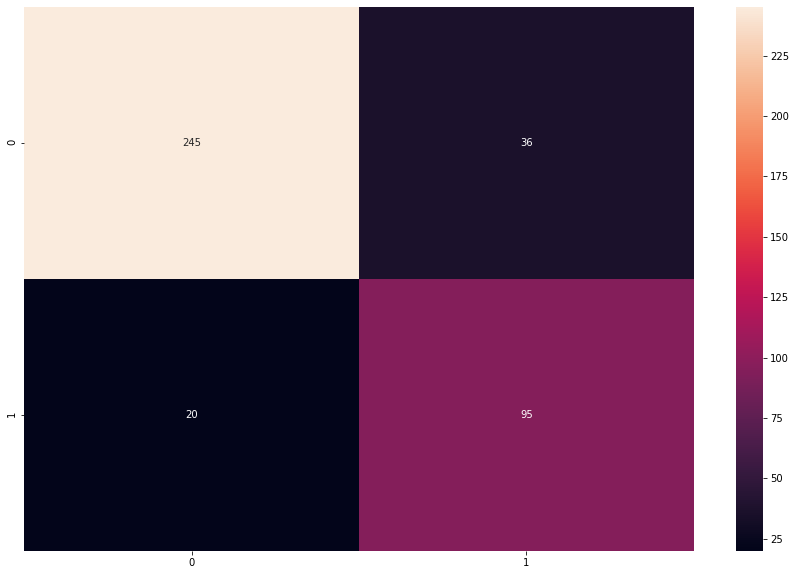

In [306]:
rf = MLPClassifier()
X_test_sel_c = X_test.loc[:,cols_c].copy()
trained_model = evaluate_model(rf, X_train_resampled_c, y_train_resampled_c, X_test_sel_c, y_test)

In [302]:

plt.rcParams['figure.figsize'] = [15, 5]
feat_imp = pd.Series(trained_model.feature_importances_, colNames_c).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [309]:
X_train_c - X_train

,ST102TA,ST103TA,ST104TA,ST105TA,ST106TA,ST107TA,ST108TA,ST109TA,ST110TA,ST111TA,...,ST84TA,ST85TA,ST90TA,ST91TA,ST93TA,ST94TA,ST95TA,ST97TA,ST98TA,ST99TA
0,0.359778,0.017682,0.191812,0.304884,0.163625,0.241810,0.191059,0.187033,0.087932,0.274547,...,0.191458,0.286596,0.047173,0.291662,0.140522,0.212785,0.179287,0.153992,0.288056,0.171379
1,0.094777,-0.238686,0.222623,0.176762,0.160963,-0.189114,0.134372,-0.173338,-0.360163,0.289229,...,0.262142,0.574721,0.507243,0.814516,0.177246,0.659695,0.273761,0.124889,-0.015581,0.477070
3,0.574405,0.301751,0.235384,0.311861,0.113576,0.344278,0.208179,0.207007,0.072147,0.393025,...,0.200312,0.255880,0.094732,0.417443,0.011686,0.216054,0.350693,0.170941,0.392957,0.262676
4,0.685934,-0.080335,0.420017,0.547526,0.478626,0.143433,0.418220,0.192609,0.525562,0.663931,...,1.025542,0.657636,0.530800,0.867672,0.328641,0.678506,0.416810,0.142934,0.120589,0.537987
6,0.505499,0.359358,0.613064,0.423081,0.679681,0.212876,0.599431,-0.681735,0.153972,0.371821,...,0.141630,0.435340,0.210858,0.614451,0.427519,0.488360,0.019936,0.512852,-0.163989,0.300740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,-0.277095,-0.029644,-0.089995,-0.117113,-0.096482,-0.159079,-0.182647,-0.298443,-0.144603,-0.194433,...,-0.118834,-0.192892,-0.279749,-0.152197,-0.200066,-0.107795,-0.222601,-0.170934,-0.179807,-0.279696
986,-0.002833,-0.106114,-0.124662,0.201298,0.086550,-0.126243,0.106892,-0.012246,0.019056,-0.106786,...,0.212708,0.125636,0.089170,0.153702,-0.051426,-0.011282,0.210750,0.076319,-0.290133,0.319111
987,-0.109636,-0.058004,-0.021941,-0.004559,-0.094162,-0.133106,-0.064567,0.001185,-0.080767,0.036639,...,-0.034396,-0.090860,0.089723,-0.083994,-0.039397,-0.183549,0.164865,-0.089651,-0.032141,0.289152
988,-0.034700,-0.029688,-0.054603,0.073156,-0.003954,-0.136070,-0.186236,0.002333,-0.123293,-0.140362,...,-0.055613,-0.084380,-0.125316,-0.076297,-0.100884,-0.073263,-0.070742,-0.025834,0.140124,-0.179219


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


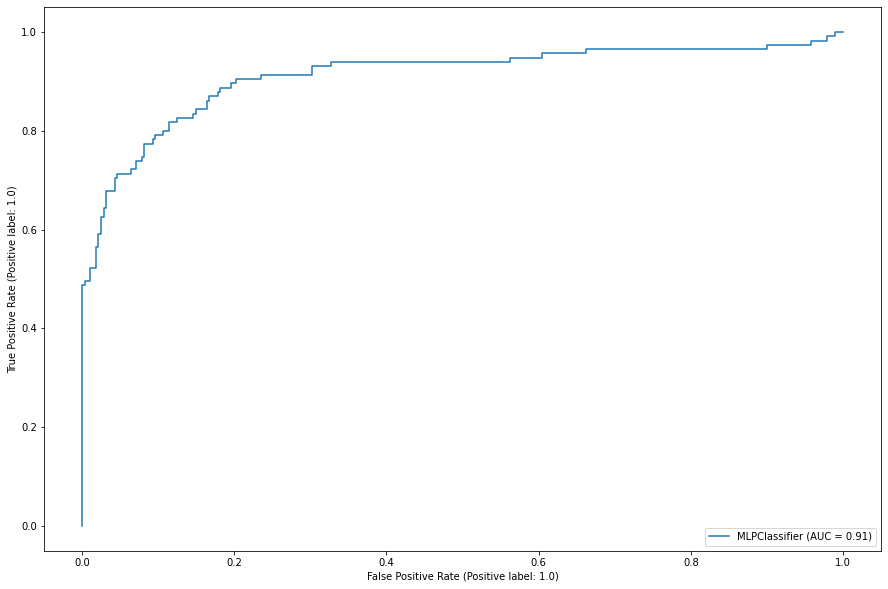

In [307]:
from sklearn.metrics import RocCurveDisplay
plt.rcParams['figure.figsize'] = [15, 10]
svc_disp = RocCurveDisplay.from_estimator(trained_model, X_test.loc[:,cols_c], y_test)


## Evolution Predictor

Here we are trying to predict whether a patient currently experiencing MCI will get alzheimer's in the future from cross-sectionnal neuroimaging data. Researchers have found that having a MCI multiplies a patient's chances of developing Alzheimer's in the future. Around 20 to 20% of people with MCI develop dementia in under a year.
This is the reason why we are trying to predict the evolution. If we are able to detect whether a patient is very likely to get alzheimer's in under 2 years then it will be easier to help the patient.

In [290]:
img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [291]:
img_adni2.replace("scmri", "sc", inplace=True)
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)

In [292]:

dx.loc[(dx["DXCHANGE"] == 1) | (dx["DXCHANGE"] == 4) |(dx["DXCHANGE"] == 6), 'DXCHANGE'] = 1
dx.loc[(dx["DXCHANGE"] == 2) | (dx["DXCHANGE"] == 5) |(dx["DXCHANGE"] == 7), 'DXCHANGE'] = 2
dx.loc[(dx["DXCHANGE"] == 3) | (dx["DXCHANGE"] == 8) |(dx["DXCHANGE"] == 9), 'DXCHANGE'] = 3


In [293]:
#CVs = []
#SVs = []
#SAs = []
#TSs = []
TAs = []
#HSs = []

for col in img_adni2.columns:
    
    #if col.endswith('CV'):
        #CVs.append(col)
    #if col.endswith('SV'):
        #SVs.append(col)
    """
    if col.endswith('SA'):
        SAs.append(col)
    if col.endswith('TS'):
        TSs.append(col)
    if col.endswith('HS'):
        HSs.append(col)
    """
    if col.endswith('TA'):
        TAs.append(col)

TAs.append("RID")
TAs2 = TAs.copy()
TAs2.append("VISCODE2")
TAs.append("VISCODE")


In [294]:
img1 = img_adni1.loc[:,TAs].copy()
img2 = img_adni2.loc[:,TAs2].copy()
img3 = img_adni3.loc[:,TAs2].copy()

In [295]:
dx_info = dx.loc[:,["RID", "VISCODE", "VISCODE2", "PTID", "DXCURREN", "DXCHANGE", "DIAGNOSIS"]].copy()
img_dx_1 = pd.merge(img1, dx_info, on=['VISCODE', 'RID'])
img_dx_2 = pd.merge(img2, dx_info, on=['VISCODE2', 'RID'])
img_dx_3 = pd.merge(img3, dx_info, on=['VISCODE2', 'RID'])

In [296]:
init_1 = img_dx_1[img_dx_1['VISCODE'] == 'bl']
init_2 = img_dx_2[img_dx_2['VISCODE2'] == 'sc']
init_3 = img_dx_3[img_dx_3['VISCODE2'] == 'sc']

In [297]:
dx_m36 = dx.loc[(dx['VISCODE'] == "m36")|( dx['VISCODE2'] == "m36")]
dx_m36_diag = dx_m36.loc[:,["PTID", "DIAGNOSIS", "DXCHANGE", "DXCURREN"]]

In [298]:
dx_img1 = pd.merge(init_1, dx_m36_diag, on=["PTID"])
dx_img2 = pd.merge(init_2, dx_m36_diag, on=["PTID"])
dx_img3 = pd.merge(init_3, dx_m36_diag, on=["PTID"])

In [299]:
dx_img = dx_img1[dx_img1['DXCURREN_x'] == 2].append(dx_img2[dx_img2['DXCHANGE_x'] == 2].append(dx_img3[dx_img3['DIAGNOSIS_x'] == 2]))

In [300]:
dx_img['DIAGNOSIS_x'] = dx_img['DIAGNOSIS_x'].fillna(dx_img['DXCHANGE_x'])
dx_img['DIAGNOSIS_x'] = dx_img['DIAGNOSIS_x'].fillna(dx_img['DXCURREN_x'])

dx_img['DIAGNOSIS_y'] = dx_img['DIAGNOSIS_y'].fillna(dx_img['DXCHANGE_y'])
dx_img['DIAGNOSIS_y'] = dx_img['DIAGNOSIS_y'].fillna(dx_img['DXCURREN_y'])

dx_img.drop(["DXCHANGE_x", "DXCHANGE_y", "DXCURREN_x", "DXCURREN_y", "VISCODE", "VISCODE2", "PTID", "RID", "DIAGNOSIS_x"], axis=1, inplace=True)


<Axes: xlabel='DIAGNOSIS_y', ylabel='Count'>

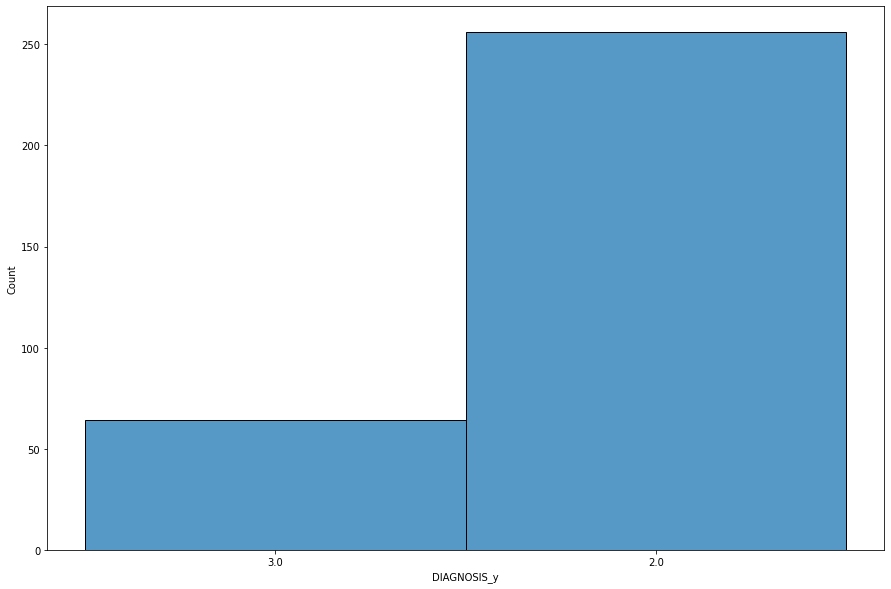

In [301]:
dx_img = dx_img[dx_img["DIAGNOSIS_y"] != 1]
sns.histplot(dx_img["DIAGNOSIS_y"].astype(str))

In [302]:
dx_img.dropna(inplace=True)
Y = dx_img["DIAGNOSIS_y"]
Y[Y==2] = 0
Y[Y==3] = 1

#SITE = dx_img['SITEID']
X = dx_img.drop(["DIAGNOSIS_y"], axis=1)

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, train_size=0.7)

In [349]:

dataset= {'data': np.array(X_train),
          'target': np.array(y_train),
          'name': 'prediction'}

classifiers = [('sklearn.ensemble', 'GradientBoostingClassifier', {}),
              ('sklearn.ensemble', 'RandomForestClassifier', {}),
              ('sklearn.neural_network', 'MLPClassifier', {}),
              ('sklearn.tree', 'DecisionTreeClassifier', {})]

oversamplers = sv.queries.get_all_oversamplers(n_quickest=2)

os_params = sv.queries.generate_parameter_combinations(oversamplers,
                                                      n_max_comb=2)

# samp_obj and cl_obj contain the oversampling and classifier objects which give the
# best performance together
samp_obj, cl_obj= sv.evaluation.model_selection(dataset=dataset,
                                                oversamplers=os_params,
                                                classifiers=classifiers,
                                                validator_params={'n_splits': 2,
                                                                  'n_repeats': 1},
                                                n_jobs= 5)

print(samp_obj)
print(cl_obj)

2023-03-10 18:09:02.342812: processing dataset: prediction
('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
RandomForestClassifier()


In [350]:
X_train_samp, y_train_samp= samp_obj.sample(np.array(X_train),
                                np.array(y_train))

2023-03-10 18:09:12,058:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-03-10 18:09:12,060:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


In [351]:
rus = RandomUnderSampler(random_state=0)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train_samp, y_train_samp)

In [352]:
featureSelector = Lasso( alpha=0.005)
featureSelector.fit(X_train_resampled, y_train_resampled)

Lasso(alpha=0.005)

In [353]:
coefficients = featureSelector.coef_

In [354]:
importance = np.abs(coefficients)

In [355]:
cols = importance != 0
colNames = np.array(TAs[:68])[importance != 0]

In [356]:
X_test = X_test.loc[:,cols].copy()
X_train_resampled = X_train_resampled[:,cols]

In [357]:
models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]

In [358]:
kfold = KFold(n_splits=10)
for model in models:
    cv_results = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold, scoring='accuracy', n_jobs=-1)
    print(model, cv_results.sum()/10)

GradientBoostingClassifier() 0.7922794117647058
RandomForestClassifier() 0.7125
SVC() 0.7933823529411764
DecisionTreeClassifier() 0.6091911764705882
MLPClassifier() 0.3900735294117647


In [359]:
param_grid={'n_estimators':[100,500], 
            'learning_rate': [0.1,0.05,0.02],
            'max_depth':[4], 
            'min_samples_leaf':[3], 
            'max_features':[1.0] } 

kfold = KFold(n_splits=10)
rf = GradientBoostingClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_resampled, y_train_resampled)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
0.8047794117647058
{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 500}


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


<Axes: >

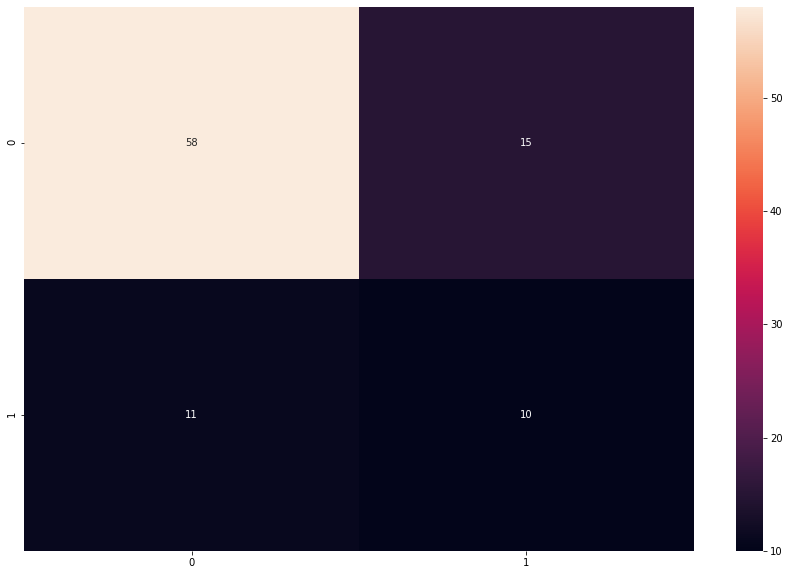

In [360]:
rf = GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=3, n_estimators=500, max_features=1.0, max_depth=4)
rf.fit(X_train_resampled, y_train_resampled)
results = rf.predict(X_test)
x = zip(results, y_test)

# Print the confusion matrix for the model
cf_matrix = sklearn.metrics.confusion_matrix(y_test, results)
sns.heatmap(cf_matrix, annot=True, fmt='g')

In [361]:
accuracy_score(y_test, results)

0.723404255319149

In [362]:
balanced_accuracy_score(y_test, results)

0.6353555120678408

Text(0, 0.5, 'Feature Importance Score')

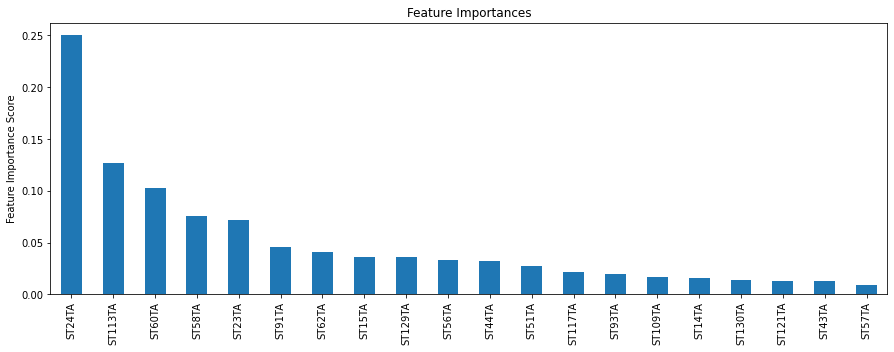

In [346]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
feat_imp = pd.Series(rf.feature_importances_, X_test.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


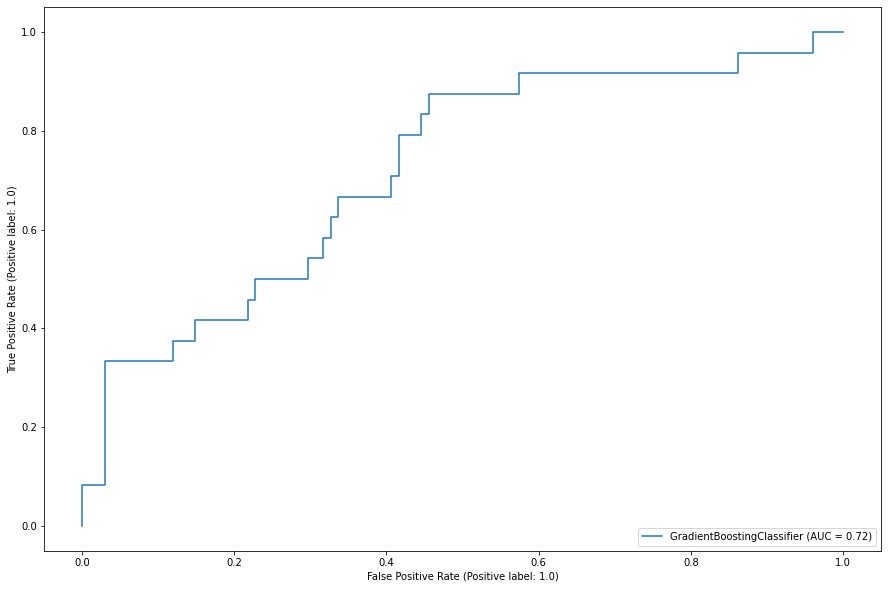

In [347]:
from sklearn.metrics import RocCurveDisplay
plt.rcParams['figure.figsize'] = [15, 10]
svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)


In [281]:
dt = DecisionTreeClassifier()
dt.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier()

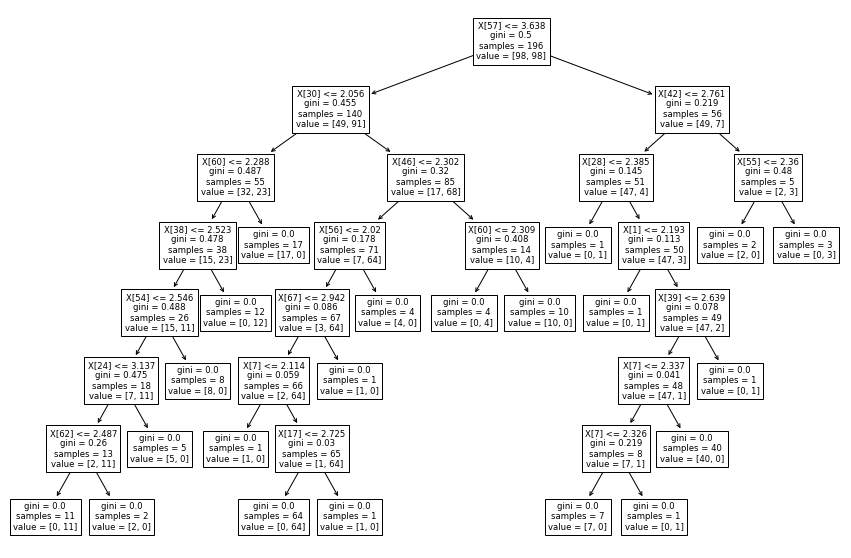

In [150]:
from sklearn.datasets import load_iris
from sklearn import tree

tree.plot_tree(dt)
plt.show()

'ST83TA'